## Problem Statment

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from
- Start: the time consumer submits the order (created_at) to
- End: when the order will be delivered to the consumer (actual_delivery_time)

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set random seed for reproducibility
np.random.seed(42)

In [3]:
# set max_columns to None to display all the columns of dataframe
pd.set_option('display.max_columns', None)

In [4]:
# read_data
historical_data = pd.read_csv("historical_data.csv")
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [5]:
# data dimension
print(f"Dataset has {historical_data.shape[0]} Rows and {historical_data.shape[1]} columns.")

Dataset has 197428 Rows and 16 columns.


In [6]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [7]:
# change the Dtype for date fields
historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])

In [8]:
# creating new features for analysis and regression
from datetime import datetime
historical_data['total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()
historical_data.head()


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [9]:
historical_data['estimated_non_prep_duration'] = historical_data['estimated_store_to_consumer_driving_duration']+historical_data['estimated_order_place_duration']
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


In [10]:
historical_data['busy_dasher_ratio'] = historical_data['total_busy_dashers']/historical_data['total_onshift_dashers']
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,estimated_non_prep_duration,busy_dasher_ratio
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


In [11]:
# check the ID fields to decide whether to encode them

historical_data['market_id'].nunique()

6

In [12]:
historical_data['order_protocol'].nunique()

7

In [13]:
historical_data['store_id'].nunique()

6743

In [14]:
store_id_unique = historical_data['store_id'].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id==store_id].store_primary_category.mode()
                        for store_id in store_id_unique}

In [15]:
def fill(store_id):
    """ Return Primary Store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# Fill null values for store category
historical_data["nan_free_store_primary_category"] = historical_data.store_id.apply(fill)

In [16]:
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,estimated_non_prep_duration,busy_dasher_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


In [17]:
## Encoding the id and category columns

order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [18]:
market_id_dummies = pd.get_dummies(historical_data.market_id).add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [19]:
store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category).add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# remove the irrelevant columns and add the dummies created earlier to the dataframe
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category',
                                'order_protocol', 'actual_delivery_time', 'nan_free_store_primary_category'])
train_df = pd.concat([train_df, market_id_dummies, order_protocol_dummies, store_primary_category_dummies], axis=1)
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,estimated_non_prep_duration,busy_dasher_ratio,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,3779.0,1307.0,0.424242,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,4024.0,1136.0,2.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,1781.0,1136.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,3075.0,735.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,2390.0,1096.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,estimated_non_prep_duration,busy_dasher_ratio,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,1.974210e+05,196902.000000,1.775900e+05,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,2.908258e+03,853.939209,NaN,0.192663,0.278876,0.118003,0.241095,0.091172,0.073191,0.277190,0.121827,0.269460,0.098031,0.224335,0.004022,0.000096,0.000588,0.000051,0.009431,0.000005,0.101429,0.000349,0.013600,0.013894,0.000010,0.001580,0.028036,0.000658,0.002700,0.057327,0.004331,0.011290,0.001935,0.001256,0.008403,0.000122,0.048139,0.000005,0.000162,0.001788,0.046002,0.005764,0.000699,0.000106,0.038247,0.001357,0.002923,0.000952,0.000329,0.000299,0.017171,0.007765,0.037690,0.000010,0.000268,0.036834,0.047724,0.009173,0.000263,0.002629,0.000582,0.000507,0.027939,0.087708,0.007501,0.000142,0.001585,0.020134,0.000699,0.003237,0.003277,0.001337,0.089227,0.000091,0.019420

In [22]:
train_df['busy_dasher_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dasher_ratio, dtype: float64

In [23]:
train_df.shape

(197428, 100)

In [24]:
# check for infinite values and replace with NaN to drop them
np.where(np.any(~np.isfinite(train_df), axis=0)==True)

(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [25]:
train_df.isna().sum().sum()

69683

In [26]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.shape

(177070, 100)

In [27]:
train_df.isna().sum().sum()

0

### Remove Redundant Features

We have 100 columns in our final dataset. This indicates that there might be redundant features. 
<br>A few of these features are not useful because they are in a way repeat of another feature or have a zero standard deviation. 
<br>Thus, they doesn't add any new information to the ML models. 
<br>Another potential problem is collinearity. 

Let's start with the correlation matrix.

<AxesSubplot: >

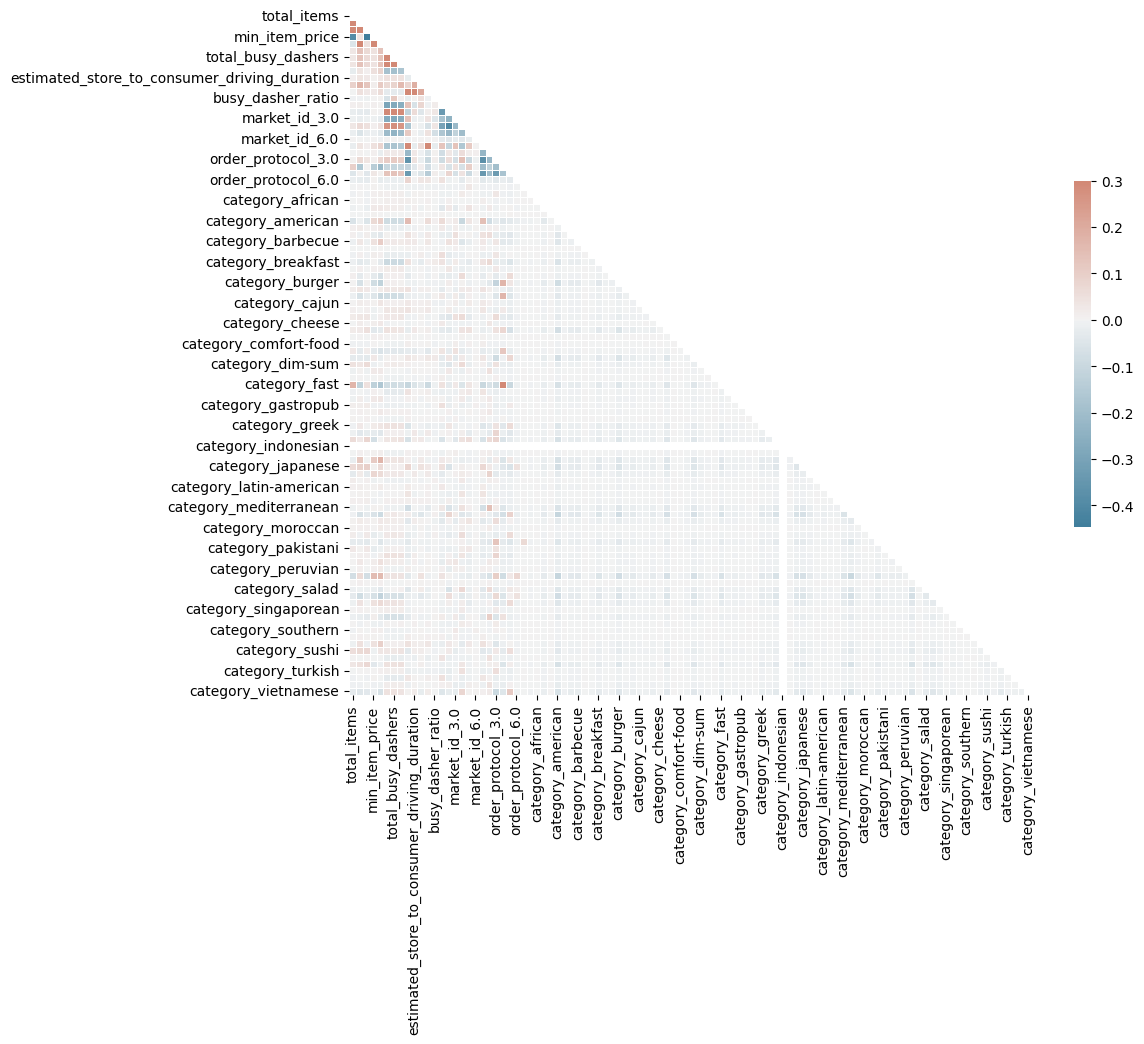

In [28]:
# since there are 100 features, for better visualization, we will take only half of triangle

# Generate a mask for upper half of triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set the matplotlib figure canvas
f, ax = plt.subplots(figsize=(11,9))

# Generate custom colourmap
cmap = sns.diverging_palette(230,20,as_cmap=True)

# Draw the heatmap with the mask and aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})

In [29]:
# categoty_indonesian looks blank. Let's check
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

It has ZERO standard deviation. We can drop this. 
<br> Let's look at the top correlated features

In [30]:
def get_redundant_pairs(df):
    """ Gets lower triangle and Diagonal pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df, n=5):
    """Sort correlations and return n highest results"""
    abs_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    abs_corr = abs_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return abs_corr[0:n]

print("Top absolute correlations")
print(get_top_correlations(train_df, 20))

Top absolute correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

3 key takeaways:
1. total_busy_dashers and total_onshift_dashers are represented by our created field 'busy_dashers_ratio'. Hence, we can drop them off
2. estimated_non_prep_duration is correlated with driving and order place duration. Let's drop the created field estimated_non_prep_duration
3. market_id values are also correlated with eachother and this will affect our regression performance. order_protocol values are also correlated with eachother and this will affect our regression performance.
    Let's not add them to the training dataset anymore

In [31]:
# drop 
    # created_at, market_id, store_id, 
    # store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns= ["created_at","market_id", "store_id",
                                "nan_free_store_primary_category", "store_primary_category",
                                "order_protocol", "actual_delivery_time"])

# Concat without market_id_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)

# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                        "category_indonesian", "estimated_non_prep_duration"])

# align dtype for entire dataset
train_df = train_df.astype('float32')

# replace inf values with np.nan and drop all NaNs
train_df.replace([np.inf,-np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dasher_ratio,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
train_df.shape

(177070, 83)

In [33]:
print("Top Absolute Correlations")
print(get_top_correlations(train_df,20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.188418
subtotal                                      total_delivery_duration           0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

Total item number or distinct items could affect the duration of the preparation process. Therefore, we don't prefer to drop them directly.
<br> Instead, let's create new columns to infer the contribution of these columns

In [34]:
# new_features

train_df['percentage_distinct_items_of_total'] = train_df["num_distinct_items"]/train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"]/train_df["total_items"]
train_df.drop(columns=['num_distinct_items','subtotal'], inplace=True)
print("Top Absolute Correlations")
print(get_top_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                    0.860580
max_item_price                                avg_price_per_item                    0.770382
min_item_price                                max_item_price                        0.541241
total_items                                   percentage_distinct_items_of_total    0.445751
                                              min_item_price                        0.389277
                                              avg_price_per_item                    0.310759
percentage_distinct_items_of_total            avg_price_per_item                    0.226711
category_pizza                                avg_price_per_item                    0.225510
estimated_store_to_consumer_driving_duration  total_delivery_duration               0.188418
max_item_price                                percentage_distinct_items_of_total    0.178021
category_fast                               

We can do the same for min max item price as well. Create a new feature to depict the price range and drop these columns

In [35]:
train_df["price_range_of_items"] = train_df["max_item_price"]-train_df["min_item_price"]
train_df.drop(columns=["max_item_price","min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_correlations(train_df))

Top Absolute Correlations
total_items                         percentage_distinct_items_of_total    0.445751
                                    price_range_of_items                  0.333304
                                    avg_price_per_item                    0.310759
percentage_distinct_items_of_total  avg_price_per_item                    0.226711
category_pizza                      avg_price_per_item                    0.225510
dtype: float64


In [36]:
train_df.shape

(177070, 82)

After the above feature engineering to solve correlation, we can now proceed to check for multicollinearity.
<br> Also, the number of features are now reduced to 82 from 100

##### Multicollinearity Check

Variance Inflation Factor(VIF) will be used.
<br> Process is to eliminate all the features with VIF score above 20.
<br> We'll drop one feature per iteration as VIF score changes with change in feature set.

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [39]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"]=features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values,i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [42]:
# apply VIF computation to all the remaining columns

features = train_df.drop(columns = ['total_delivery_duration']).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000498
2,category_belgian,1.000760
3,category_russian,1.003231
4,category_african,1.003823
...,...,...
76,busy_dasher_ratio,6.369601
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210844
79,estimated_order_place_duration,13.472279


In [44]:
# Let's drop feature with VIF>20

multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print(f"{highest_vif_feature} will be removed")
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF>20])==0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

percentage_distinct_items_of_total will be removed


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000369
2,category_belgian,1.000461
3,category_russian,1.002022
4,category_gluten-free,1.002372
...,...,...
75,category_american,4.505928
76,avg_price_per_item,5.958972
77,busy_dasher_ratio,6.357889
78,estimated_store_to_consumer_driving_duration,7.192644


##### Feature Selection

To reduce the noise in the model and decrease the trianing duration, we can use only a subset of the features in the modeling part.
<br> Hence, let's investigate Feature importance.

To do this, let's use Random forest regressor to get the importance of each feature in prediction of the total delivery duration

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# split the data
X = train_df[selected_features]
y= train_df['total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's sort the features based on importance and visualize them

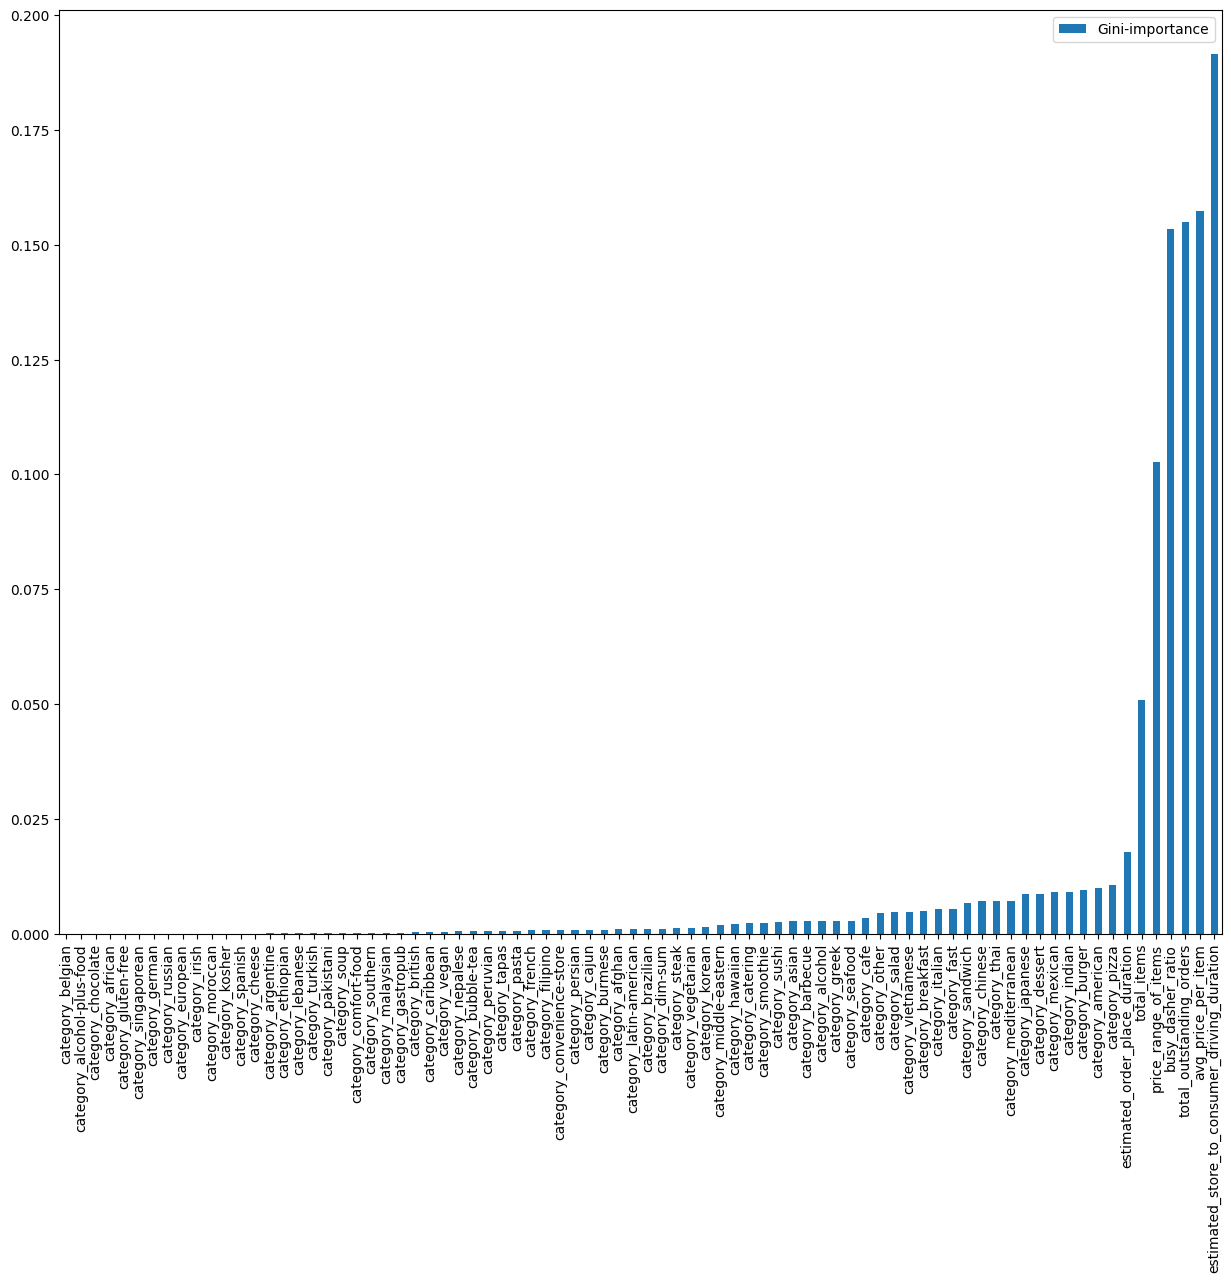

In [48]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
# hashmap to hold feature name and its importance
feats = {}
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()


Let's check the most important ones

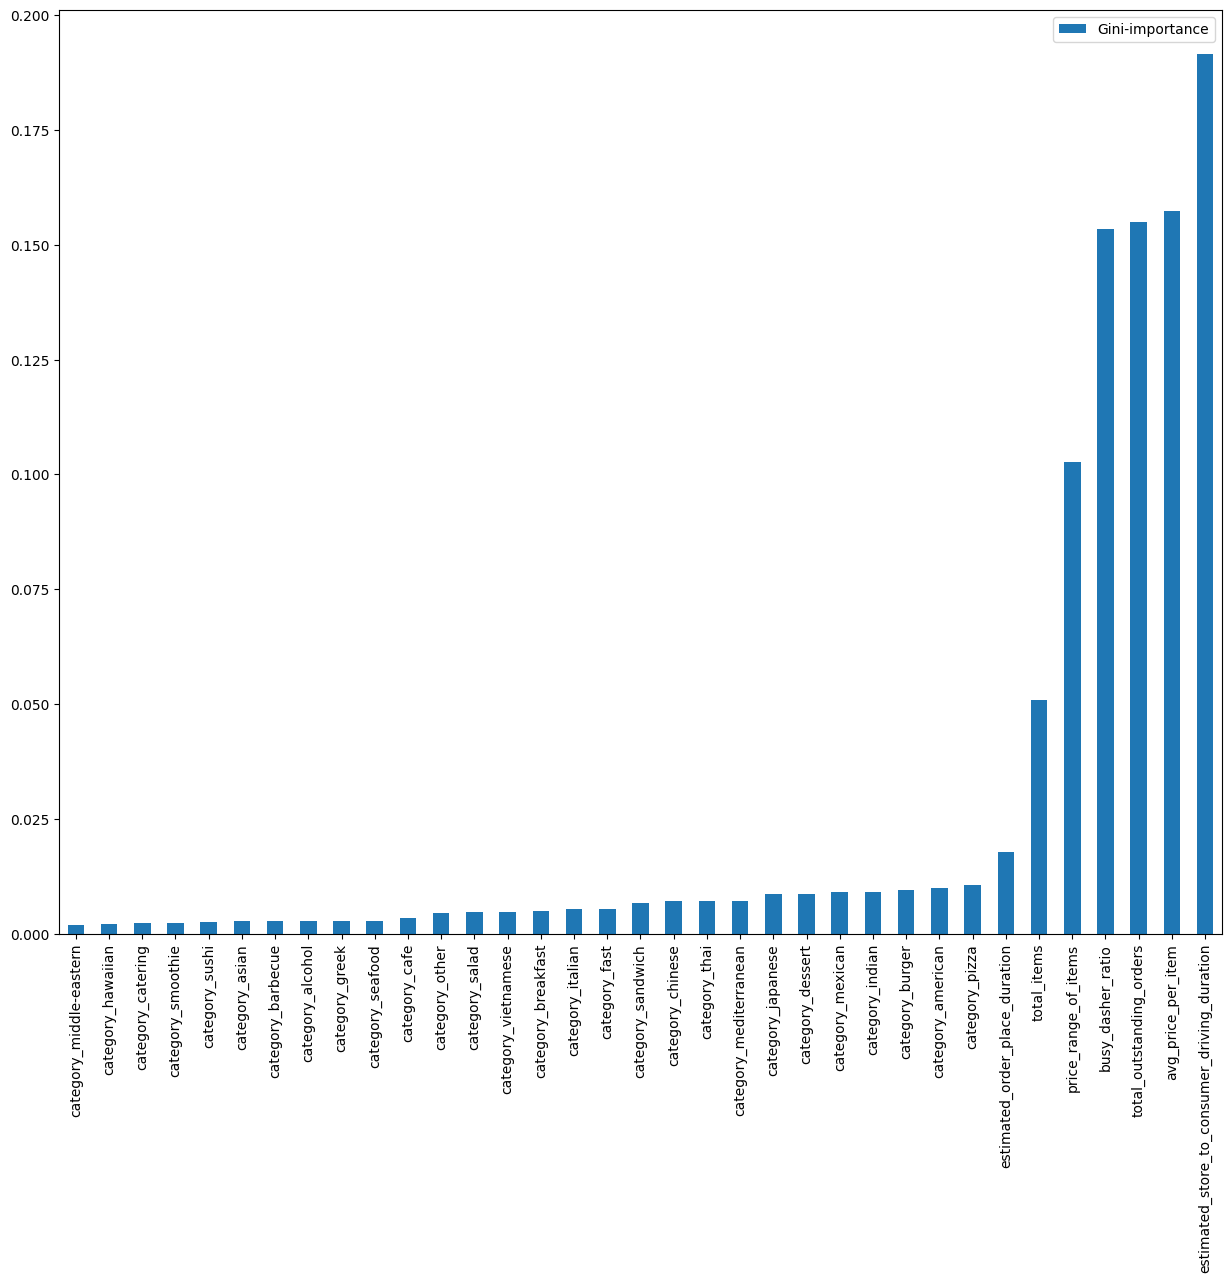

In [51]:
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

As per expectation, estimated store to consumer driving duration is a highly contributing factor to determine the total delivery duration.
Let's use this important features for the final features subset

In [52]:
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dasher_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

Another method to reduce features is using PCA (Principal Component Analysis). It maps all features to another dimension and interprets all varainces in a data frame

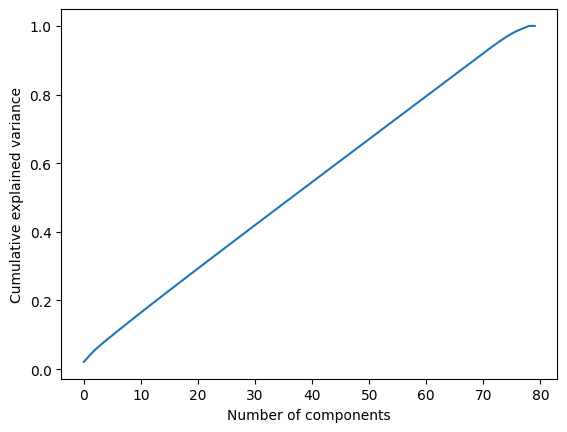

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_train = X_train.values
X_train = np.array(X_train)

# Applying Standard Scalar
X_std = StandardScaler().fit_transform(X_train)
pca = PCA().fit(X_std)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

PCA doesn't plateau untill after 80 features and hence, cannot explain variance with less than 80 features. Since we already have 80 features, we can use the necessary ones from the feature importance step earlier.

##### Feature Scaling

From data exploration, we can see that there is a significant difference between min and max values.
<br> For the sake of regression performance, its best to scale these to a common ground.

In [54]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """ Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, X_scaler, y_scaler

Since we applied a scaler to training data, the predictions for test data will also be scaled. 
<br> Hence, we apply inverse transformation. We'll be using RMSE to measure error as its sensitive to high error terms.

In [55]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transfrom(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    #return RMSE with squared False
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print(f"Error = {rmse_error} in {model_name}")

    return rmse_error, y_predict

#### Classical Machine Learning

Let's experiment with the regressors

In [56]:
def make_regression(X_train, X_test, y_train, y_test, model, model_name, verbose=True):
    """Train the model and measure the error"""
    model.fit(X_train, y_train)
    y_predict_train = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict_train, squared=False)
    y_predict_test = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict_test, squared=False)
    if verbose==True:
        print(f"Train error = {train_error} in {model_name}")
        print(f"Test error = {test_error} in {model_name}")
    trained_model = model
    return trained_model, y_predict_test, train_error, test_error
    


Let's experiment with different regressors, feature sets, scalers and store the error in dictionary. 
<br> This will then be plotted and used to compare and see for the best performing model

In [57]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, LinearRegression

pred_dict = {
    "regression_model": [],
    "feature_set" : [],
    "scaler_name": [],
    "RMSE":[]
}

regression_models = {
    "Ridge": Ridge(),
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "AdaBoost": AdaBoostRegressor()
}

feature_sets = {
    "full_dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "NoScale": None
}

In [58]:
## Regression

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"------scaled with {scaler_name}------included columns are {feature_set_name}")
        print(" ")
        for model_name in regression_models.keys():
            if scaler_name == "NoScale":
                X = train_df[feature_set]
                y = train_df["total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, X_test, y_train, y_test, regression_models[model_name], model_name, verbose=True)
            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict, _,_ = make_regression(X_train, X_test, y_train[:,0], y_test[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transfrom(y_scaler, y_test, y_predict, model_name)               

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------scaled with StandardScaler------included columns are full_dataset
 
Error = 2884.732177734375 in Ridge
Error = 2884.733154296875 in LinearRegression
Error = 2890.0765441000485 in DecisionTree
Error = 2933.1782596557305 in RandomForest
Error = 2904.4189453125 in XGBoost
Error = 5499.380627280224 in AdaBoost
------scaled with MinMaxScaler------included columns are full_dataset
 
Error = 2884.431884765625 in Ridge
Error = 2885.07080078125 in LinearRegression
Error = 2890.124408577283 in DecisionTree
Error = 2933.134498518134 in RandomForest
Error = 2904.78857421875 in XGBoost
Error = 8631.836448937156 in AdaBoost
------scaled with NoScale------included columns are full_dataset
 


c:\Naveen\CodeRepo\DeliveryDurationPrediction\venv\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.42528e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1071.4970703125 in Ridge
Test error = 2053.692626953125 in Ridge
Train error = 1071.5057373046875 in LinearRegression
Test error = 2053.681396484375 in LinearRegression
Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 396.249964266449 in RandomForest
Test error = 2049.1982750103775 in RandomForest
Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
Train error = 5389.996272854703 in AdaBoost
Test error = 5692.225015473438 in AdaBoost
------scaled with StandardScaler------included columns are selected_features_40
 
Error = 2884.1982421875 in Ridge
Error = 2884.19873046875 in LinearRegression
Error = 2889.65037011208 in DecisionTree
Error = 2939.2043859759206 in RandomForest
Error = 2904.305419921875 in XGBoost
Error = 8021.446669705268 in AdaBoost
------scaled with MinMaxScaler------included columns are selected_features_40
 
Error = 2883.89404296875 in Ridge
Error = 2884.53393554

c:\Naveen\CodeRepo\DeliveryDurationPrediction\venv\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1072.35498046875 in LinearRegression
Test error = 2054.00390625 in LinearRegression
Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 399.27752509051646 in RandomForest
Test error = 2047.6579245173605 in RandomForest
Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
Train error = 5033.865392091473 in AdaBoost
Test error = 5343.924285868666 in AdaBoost
------scaled with StandardScaler------included columns are selected_features_20
 
Error = 2883.184814453125 in Ridge
Error = 2883.18505859375 in LinearRegression
Error = 2887.9154944530874 in DecisionTree
Error = 2945.8390393466457 in RandomForest
Error = 2904.060546875 in XGBoost
Error = 4120.716586736269 in AdaBoost
------scaled with MinMaxScaler------included columns are selected_features_20
 
Error = 2882.882080078125 in Ridge
Error = 2883.523193359375 in LinearRegression
Error = 2887.9635429627656 in DecisionTree
Error = 2945.

c:\Naveen\CodeRepo\DeliveryDurationPrediction\venv\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.43857e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1074.506591796875 in LinearRegression
Test error = 2055.365478515625 in LinearRegression
Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 395.06303432838064 in RandomForest
Test error = 2048.7214312294745 in RandomForest
Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
Train error = 4494.0248701048 in AdaBoost
Test error = 4861.14361502057 in AdaBoost
------scaled with StandardScaler------included columns are selected_features_10
 
Error = 2882.7646484375 in Ridge
Error = 2882.76513671875 in LinearRegression
Error = 2888.1272858249868 in DecisionTree
Error = 2952.005976266175 in RandomForest
Error = 2904.4013671875 in XGBoost
Error = 5519.695197886473 in AdaBoost
------scaled with MinMaxScaler------included columns are selected_features_10
 
Error = 2882.416748046875 in Ridge
Error = 2883.101318359375 in LinearRegression
Error = 2888.1753623700242 in DecisionTree
Error = 2953.

In [59]:
pred_df = pd.DataFrame(pred_dict)

In [60]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full_dataset,StandardScaler,2884.732178
1,LinearRegression,full_dataset,StandardScaler,2884.733154
2,DecisionTree,full_dataset,StandardScaler,2890.076544
3,RandomForest,full_dataset,StandardScaler,2933.178260
4,XGBoost,full_dataset,StandardScaler,2904.418945
...,...,...,...,...
67,LinearRegression,selected_features_10,NoScale,4498.851812
68,DecisionTree,selected_features_10,NoScale,4498.851812
69,RandomForest,selected_features_10,NoScale,4498.851812
70,XGBoost,selected_features_10,NoScale,4498.851812


<AxesSubplot: >

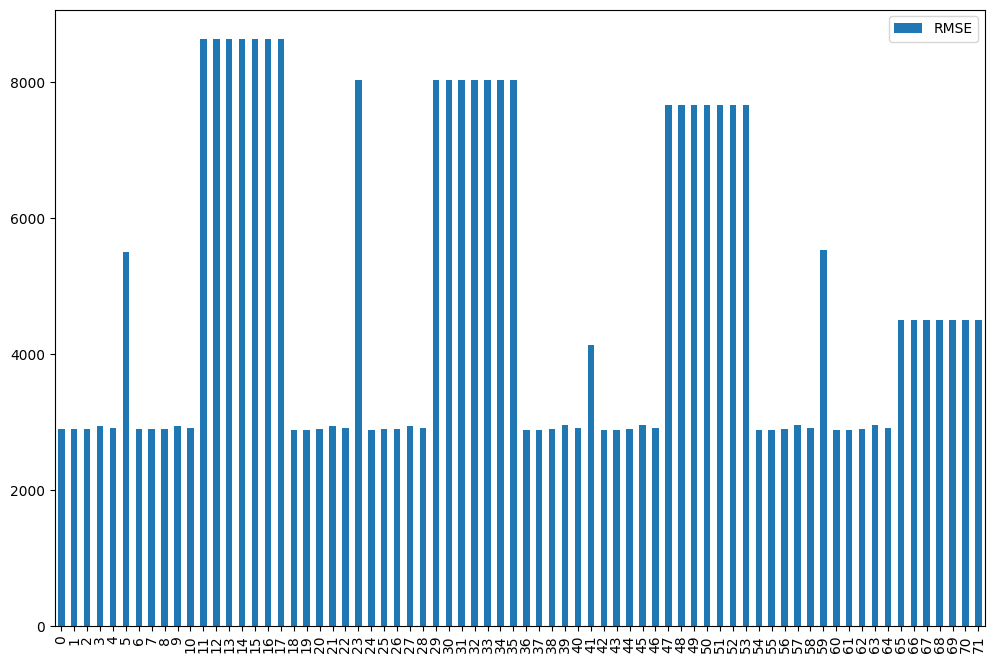

In [61]:
pred_df.plot(kind='bar', figsize=(12,8))

There are high errors for all the models.

Key observations
1. Not scaling affects the model performance. Hence, pick any of the 2 scalers and proceed.
2. Number of features at 40 leads to better model.

Since error rates are high, what can be done to improve the model?

One idea could be to predict the prep time and use the given estimated store to consumer driving duration and order place time to sum up and find the total delivery duration.

In [62]:
train_df['prep_time'] = train_df["total_delivery_duration"] - train_df['estimated_store_to_consumer_driving_duration'] - train_df['estimated_order_place_duration']

pred_dict_v2 = {
    "regression_model":[],
    "feature_set":[],
    "scaler_name":[],
    "RMSE":[]
}
scalers = {
    "StandardScaler": StandardScaler()
}

feature_sets = {
    "selected_features_40": importances.sort_values(by="Gini-importance")[-40:].index.tolist()
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=['estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration'])
            y = train_df['prep_time']

            X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            #scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            # regression modelling
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict, _,_ = make_regression(X_train, X_test, y_train[:,0], y_test[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transfrom(y_scaler,y_test, y_predict, model_name)

            pred_dict_v2["regression_model"].append(model_name)
            pred_dict_v2["feature_set"].append(feature_set_name)
            pred_dict_v2["scaler_name"].append(scaler_name)
            pred_dict_v2["RMSE"].append(rmse_error)

-----scaled with StandardScaler-------- included columns are selected_features_40

Error = 2021.489501953125 in Ridge
Error = 2021.4898681640625 in LinearRegression
Error = 2031.9142895724087 in DecisionTree
Error = 2097.127539551453 in RandomForest
Error = 2051.395263671875 in XGBoost
Error = 7055.5732756306725 in AdaBoost
